In [126]:
# Import packages
import xarray as xr
import numpy as np
import math
import matplotlib.pyplot as plt

In [127]:

ds_history = xr.open_dataset('/Users/noahday/GitHub/icepack-dirs/runs/icepackfluff/history/icepack.h.20150101.nc')
ds_history

<xarray.Dataset>
Dimensions:   (ni: 4, ncat: 5, ntrcr: 22, time: 8760)
Coordinates:
  * ni        (ni) int32 1 2 3 4
  * ncat      (ncat) int32 1 2 3 4 5
  * ntrcr     (ntrcr) int32 1 2 3 4 5 6 7 8 9 10 ... 14 15 16 17 18 19 20 21 22
  * time      (time) object 2015-01-01 01:00:00 ... 2016-01-01 00:00:00
Data variables: (12/39)
    timestep  (time) int32 ...
    date      (time) float64 ...
    aice      (time, ni) float64 ...
    vice      (time, ni) float64 ...
    vsno      (time, ni) float64 ...
    uvel      (time, ni) float64 ...
    ...        ...
    fhocn     (time, ni) float64 ...
    aicen     (time, ncat, ni) float64 ...
    vicen     (time, ncat, ni) float64 ...
    vsnon     (time, ncat, ni) float64 ...
    trcr      (time, ntrcr, ni) float64 ...
    trcrn     (time, ncat, ntrcr, ni) float64 ...

In CICE the mean ice thickness is$$ h_i = \sum_{n = 1}^{N_c} \textrm{vicen}(n)$$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'days')

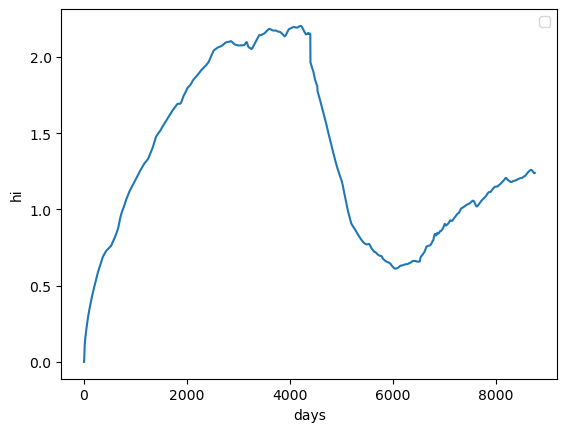

In [128]:
var = 'hi'
column_test = 0
#for i in range(1,2):
#    plt.plot(np.linspace(0,365,365*24), ds[var][(i-1)*365*24:i*365*24,column_test], label = str(i))
if var == 'hi':
    plot_data = ds_history.vicen.sum(dim='ncat')
else:
    plot_data = ds_history[var]
plt.plot(plot_data[:,column_test])
plt.legend()
plt.ylabel(var)
plt.xlabel('days')

# Editing the intial conditions for a simulation

In [311]:
NCAT = np.array([6.4450723e-01, 1.3914335e+00, 2.4701793e+00, 4.5672879e+00, 1.0000000e+08])

desired_initial_thickness = 0.05 # m
# Open the file
ds_restart = xr.open_dataset('/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced.2016-01-01-00000.nc')
ds_restart
puny = 10**(-12)
thicknesses = ds_restart['vicen'][:,column_test]/ds_restart['aicen'][:,column_test]
temp_aicen = [1.0, puny, puny, puny, puny]*(0.05/thicknesses)
temp_vicen = thicknesses*temp_aicen
temp_vicen.sum()
#divisor = ds_restart['vicen'].sum(dim='ncat')[column_test]/desired_initial_thickness
#temp = ds_restart['vicen'][:,column_test]/divisor
#temp.sum()

#temp = np.zeros(5)
#temp[0] = ds_restart['vicen'].sum(dim='ncat')[column_test]/20
# Save to a new file
#ds.to_netcdf('/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced.2015-02-01-00000-5cm.nc')

<xarray.DataArray ()>
array(0.05)

In [237]:
prescribed_conc

<xarray.DataArray (ncat: 5)>
array([0.15072847, 0.        , 0.        , 0.        , 0.        ])
Dimensions without coordinates: ncat

In [240]:
NCAT

array([6.4450723e-01, 1.3914335e+00, 2.4701793e+00, 4.5672879e+00,
       1.0000000e+08])

From Bitz et al., *JGR*, (2001):
> The thickness-distribution, $g(h)$, for $N_C$ categories is written
> $$ g(h) = g_0\delta(h) + \sum_{i=1}^{N_C} g_i \delta(h-H_i)$$
> where $M$ is the number of ice categories, $\delta(h)$ is the Dirac delta function, $H_i$ is the thickness, and $g_i$ is the concentration within category $i$ (category 0 is open water). $H_i$ varies in time and is constrained to range between the limits $\hat{H}_{i-1}$ to $\hat{H}_i$ (with $\hat{H}_{-1} = 0$, $\hat{H}_0 = 10$ cm, ... $\hat{H}_M = \infty$).

In [296]:
# Verify that the thicknesses do not escape their bins

def constrain_thickneses(vicen_in, aicen_in):
    # NCAT taken from CICE input file
    thicknesses = vicen_in/aicen_in # Bitz
    upper_bounds = np.array([6.4450723e-01, 1.3914335e+00, 2.4701793e+00, 4.5672879e+00, 1.0000000e+08])
    lower_bounds = np.insert(upper_bounds[0:-1], 0, 0)
    thickness_greater = (thicknesses > upper_bounds).all()
    thickness_not_smaller = (thicknesses < lower_bounds).all()

    if (thickness_greater).any():
        print('ERROR: Thickness exceeds upper bounds')
        print(thicknesses)
        print(upper_bounds)
    if (thickness_not_smaller).any():
        print('ERROR: Thickness subceeds lower bounds')
        print(thicknesses)
        print(lower_bounds)
    
#temp_thickness = (temp_vicen / ds_restart['aicen'][:, column_test]).values
temp_thickness = np.insert(NCAT[0:-1], 0, 0) + 0.05
PUNY = 10**(-12)
temp_aicen = np.array([1.0 - 4*PUNY, PUNY, PUNY, PUNY, PUNY])
temp_vicen = temp_thickness*temp_aicen
constrain_thickneses(temp_vicen, temp_aicen)
#constrain_thickneses(temp_vicen, ds_restart['aicen'][:, column_test])
#constrain_thickneses(ds_restart['vicen'][:, column_test], ds_restart['aicen'][:, column_test])

# if (temp_vicen/ds_restart['aicen'][:,column_test] > NCAT).any():
#     print('error')
#     print(temp_vicen/ds_restart['aicen'][:,column_test]/10)
print(temp_vicen/temp_aicen)

[0.05       0.69450723 1.4414335  2.5201793  4.6172879 ]


In [303]:
temp_aicen.sum()

ds_restart['aicen'][:, column_test].sum()

<xarray.DataArray 'aicen' ()>
array(0.99821864)

In [290]:
print(ds_restart['vicen'][:, column_test]/ds_restart['aicen'][:, column_test])
#print(NCAT)

<xarray.DataArray (ncat: 5)>
array([0.33172234, 0.9690101 , 1.54509758, 2.90202255, 7.08145963])
Dimensions without coordinates: ncat


In [306]:
ds_restart['aicen'][:, column_test].sum()

<xarray.DataArray 'aicen' ()>
array(0.99821864)

In [291]:
np.insert(NCAT[0:-1], 0, 0) + 0.1

array([0.1       , 0.74450723, 1.4914335 , 2.5701793 , 4.6672879 ])

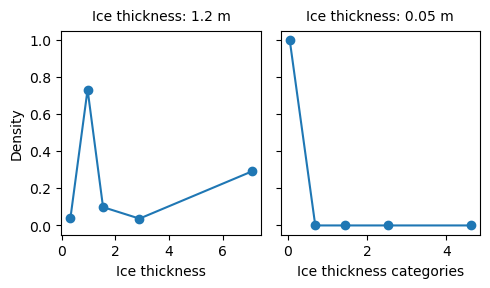

In [310]:
fig, axes = plt.subplots(1,2, figsize=[5, 3], sharey=True)
axes[0].plot(ds_restart['vicen'][:,column_test]/ds_restart['aicen'][:,column_test], ds_restart['vicen'][:,column_test], 'o-')
axes[0].set_xlabel('Ice thickness')
axes[0].set_ylabel('Density')
axes[0].text(0.5, 1.05, 'Ice thickness: ' + str(np.round(ds_restart['vicen'].sum(dim='ncat')[column_test].values, 3))+' m', ha='center', transform=axes[0].transAxes)

axes[1].plot(temp_vicen/temp_aicen, temp_aicen, 'o-')
axes[1].set_xlabel('Ice thickness categories')
axes[1].text(0.5, 1.05, 'Ice thickness: ' + str(np.round(temp_vicen.sum(), 3))+' m', ha='center', transform=axes[1].transAxes)

plt.tight_layout()

If all looks correct, then save the new ITD as a NetCDF4 file.

In [314]:
# Read the NetCDF file
file_path = '/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced.2016-01-01-00000.nc'
ds_restart = xr.open_dataset(file_path)

# Modify the variables
# Here, we simply demonstrate an example by doubling the values.
# Replace this with your actual modification logic.
ds_temp = ds_restart
ds_temp['aicen'][:,column_test] = temp_aicen
ds_temp['vicen'][:,column_test] = temp_vicen
print(ds_temp['aicen'][:,column_test].values - temp_aicen)
# Save the modified dataset to a new file
new_file_path = '/Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced_5cm.2016-01-01-00000.nc'
ds_temp.to_netcdf(new_file_path)

print(f"Modified dataset saved to: {new_file_path}")

<xarray.DataArray (ncat: 5)>
array([0., 0., 0., 0., 0.])
Dimensions without coordinates: ncat
Modified dataset saved to: /Users/noahday/GitHub/icepack-dirs/runs/icepack_test0/restart/iced_5cm.2016-01-01-00000.nc


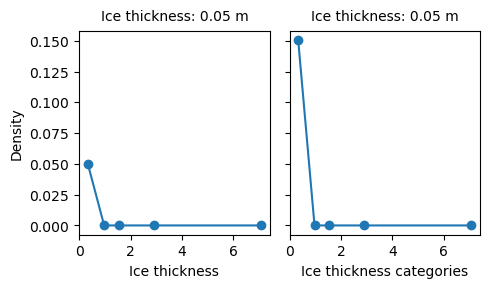

In [317]:
fig, axes = plt.subplots(1,2, figsize=[5, 3], sharey=True)
axes[0].plot(ds_temp['vicen'][:,column_test]/ds_temp['aicen'][:,column_test], ds_temp['vicen'][:,column_test], 'o-')
axes[0].set_xlabel('Ice thickness')
axes[0].set_ylabel('Density')
axes[0].text(0.5, 1.05, 'Ice thickness: ' + str(np.round(ds_temp['vicen'].sum(dim='ncat')[column_test].values, 3))+' m', ha='center', transform=axes[0].transAxes)

axes[1].plot(temp_vicen/temp_aicen, temp_aicen, 'o-')
axes[1].set_xlabel('Ice thickness categories')
axes[1].text(0.5, 1.05, 'Ice thickness: ' + str(np.round(temp_vicen.sum().values, 3))+' m', ha='center', transform=axes[1].transAxes)

plt.tight_layout()

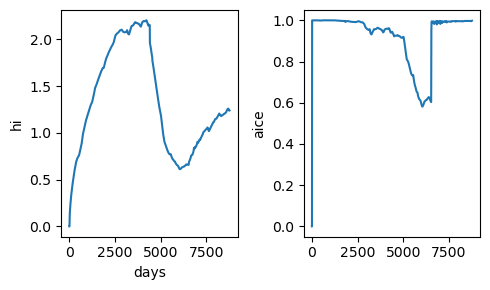

In [334]:
def get_icepack_var(var, column_test=0):
    if var == 'hi':
        plot_data = ds_history.vicen.sum(dim='ncat')
    else:
        plot_data = ds_history[var]
    return plot_data[:,column_test]

ds_history = xr.open_dataset('/Users/noahday/GitHub/icepack-dirs/runs/icepackfluff/history/icepack.h.20150101.nc')
ds_history


fig, axes = plt.subplots(1,2, figsize=[5, 3], sharex=True)
var = 'hi'
axes[0].plot(get_icepack_var(var))
axes[0].set_ylabel(var)
axes[0].set_xlabel('days')

var = 'aice'
axes[1].plot(get_icepack_var(var))
axes[1].set_ylabel(var)
plt.tight_layout()

In [323]:
plot_data[2]

<xarray.DataArray 'vicen' (ni: 4)>
array([0.        , 2.00152231, 2.57168621, 0.        ])
Coordinates:
  * ni       (ni) int32 1 2 3 4
    time     object 2015-01-01 03:00:00